# Trapped ion pulse sequence simulation

### 1. Mesolve approach

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


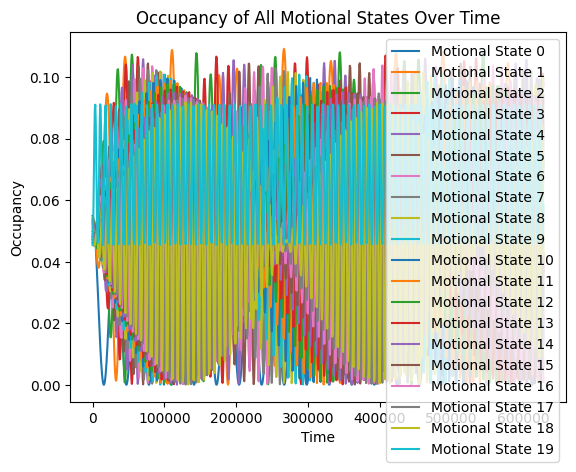

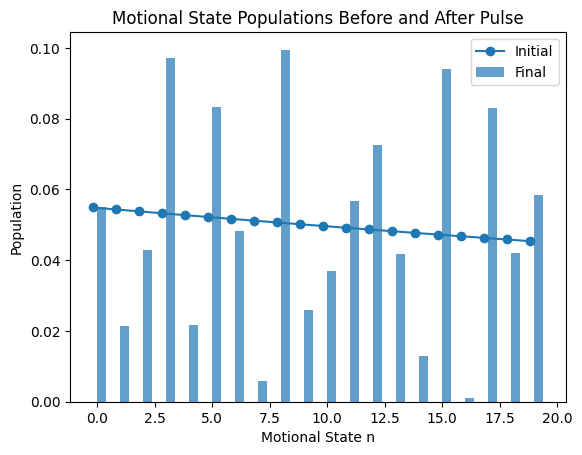

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.01  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 0  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Displacement operator
D_eta = displace(N, (1j * eta)/2)
D_eta_full = tensor(qeye(2), D_eta)

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(sigmay(), qeye(N))
s_x_full = tensor(sigmax(), qeye(N))

# Original Hamiltonian
# H = Delta/2 * s_z_full + nu * a_dag_full * a_full + Omega/2 * (s_plus_full*D_eta_full + s_minus_full*D_eta_full.dag())

# Red sideband Hamiltonian
H = 1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)

# First apply a displacement operator for i*eta/2
H = D_eta_full * H * D_eta_full.dag()

# Then apply a y pulse of pi/2
H = (1j * np.pi / 4 * s_y_full).expm() * H * (-1j * np.pi / 4 * s_y_full).expm().dag()

# Now apply an x pulse of duration tau
H = (1j * np.pi / 4 * s_x_full).expm() * H * (-1j * np.pi / 4 * s_x_full).expm().dag()

# Undo the y pulse
H = (-1j * np.pi / 4 * s_y_full).expm().dag() * H * (1j * np.pi / 4 * s_y_full).expm()

# Undo the displacement operator
H = D_eta_full.dag() * H * D_eta_full

# Spin relaxation collapse operators
c_ops = []
c_ops.append(np.sqrt(gamma) * s_minus_full)

# Initial state: thermal state for motion and ground state for spin
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr()  # Normalize
ground_state = basis(2, 1)  # |g>
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Time evolution using Qutip mesolve
T_pulse = 20 * tau # Total time for pulse sequence
times_pulse = np.linspace(0, T_pulse, 1000)
result_pulse = mesolve(H, initial_state, times_pulse, c_ops, [])

# Extract the occupancy of all motional states at all time points
occupancies = np.array([state.ptrace(1).diag().real for state in result_pulse.states])

# Plot the occupancy of all motional states over time
for n in range(N):
    plt.plot(times_pulse, occupancies[:, n], label=f'Motional State {n}')
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.title('Occupancy of All Motional States Over Time')
plt.legend()
plt.show()

# Bar plot of motional state populations before and after the pulse
p_motional_initial = initial_state.ptrace(1).diag().real
p_motional_final = result_pulse.states[-1].ptrace(1).diag().real
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('Motional State Populations Before and After Pulse')
plt.legend()
plt.show()

### 2. Liouvillian operator approach

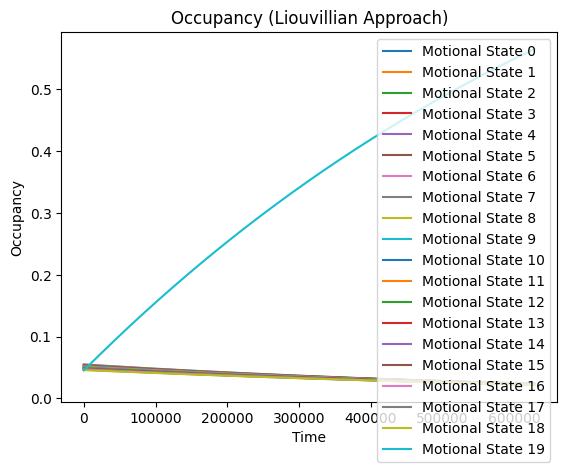

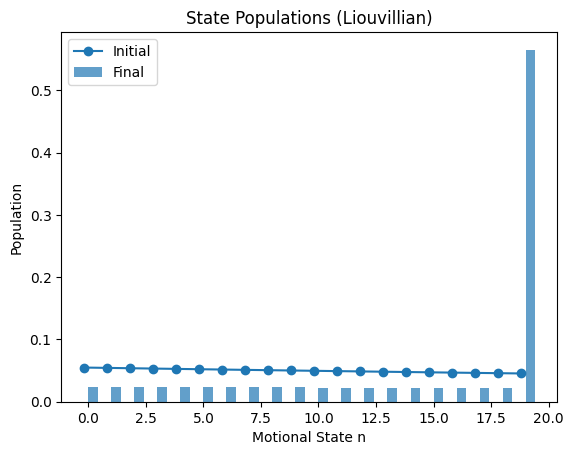

In [ ]:
# Define operators locally to ensure they are available
sm = sigmam()
a = destroy(N) # Assumes N is defined globally from previous cell
xop = a + a.dag()

# Diffusion term of spontaneous emission (Recoil)
carrier_c_ops = []
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / sum(W)

# Trapped state Lindbladians parameters
G = 1.5 * Omega
Gamma = 2 * G # Effective decay rate

for i, c in enumerate(cosal):
    # Collapse operator: Spin (sm) ⊗ Motion (Displacement)
    # Must match Hamiltonian structure: tensor(Spin, Motion)
    DD = tensor(sm, (1j * c * eta * xop).expm())
    
    # Each recoil component is a collapse operator with rate Gamma * W[i]
    rate = Gamma * W[i]
    carrier_c_ops.append(np.sqrt(rate) * DD)

# Construct Liouvillian for the Pulse Hamiltonian H (from previous cell)
# H is expected to be Spin ⊗ Motion
L = liouvillian(H, carrier_c_ops)

# Time evolution using Liouvillian
# mesolve can take a Liouvillian superoperator as the Hamiltonian argument
# collapse operators are empty because they are already inside L
options = {"nsteps": 50000} 
result_liouv = mesolve(L, initial_state, times_pulse, [], [], options=options)

# --- Plotting (Same as Mesolve section) ---

# Extract the occupancy of all motional states at all time points
occupancies_liouv = np.array([state.ptrace(1).diag().real for state in result_liouv.states])

# Plot the occupancy of all motional states over time
plt.figure()
for n in range(N):
    plt.plot(times_pulse, occupancies_liouv[:, n], label=f'Motional State {n}')
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.title('Occupancy (Liouvillian Approach)')
plt.legend()
plt.show()

# Bar plot of motional state populations before and after the pulse
p_motional_initial = initial_state.ptrace(1).diag().real
p_motional_final = result_liouv.states[-1].ptrace(1).diag().real

plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations (Liouvillian)')
plt.legend()
plt.show()